# **Imports and Installations**

In [ ]:
!sudo apt install -y fluidsynth
!pip install --upgrade pyfluidsynth
!pip install pretty_midi
!pip install MIDIUtil

In [ ]:
import pandas as pd
import numpy as np
import glob
import json
import os
import pretty_midi
import pathlib
import shutil
import time
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

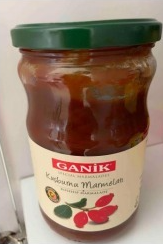

# **Preprocessing**

In [ ]:
composer_list = ["Wolfgang Amadeus Mozart", "Franz Schubert", "Frédéric Chopin", "Ludwig van Beethoven", "Johann Sebastian Bach"]

maestro_metadata = pd.read_csv("./maestro/maestro-v3.0.0.csv")
maestro_metadata = maestro_metadata[maestro_metadata['canonical_composer'].isin(composer_list)]

for composer in composer_list:
    metadata = maestro_metadata[maestro_metadata['canonical_composer']==composer]
    os.makedirs(f"./extracted_midis/{composer}/midis", exist_ok=True)

    for row in metadata.iterrows():
        idx = row[0]
        row = row[1]

        file_path = "./maestro/" + row["midi_filename"]
        shutil.copy(file_path, f"./extracted_midis/{composer}/midis/{idx}.mid")

In [ ]:
filenames = glob.glob("./extracted_midis/**/midis/*.mid")
print('Number of files:', len(filenames))

In [ ]:
for idx, filename in enumerate(filenames):
    _id = filename.split("\\")[-1].split(".")[0]
    print(idx, _id, filename)

    pm = pretty_midi.PrettyMIDI(filename)
    instrument = pm.instruments[0]

    columns = ["start(sec)", "end(sec)", "time_interval(sec)", "duration(sec)", "instrument", "velocity", "pitch", "note"]
    metadata = pd.DataFrame({col: [None] * (len(instrument.notes)-1) for col in columns})

    for idx, note in enumerate(instrument.notes):
        metadata["start(sec)"][idx] = note.start.round(3)
        metadata["end(sec)"][idx] = note.end.round(3)
        metadata["time_interval(sec)"][idx] = str(note.start.round(3)) + "-" + str(note.end.round(3))
        metadata["duration(sec)"][idx] = (note.end - note.start).round(3)
        metadata["instrument"][idx] = instrument.program
        metadata["velocity"][idx] = note.velocity
        metadata["pitch"][idx] = note.pitch
        metadata["note"][idx] = pretty_midi.note_number_to_name(note.pitch)
    metadata.sort_values("start(sec)", ascending=True, inplace=True)

    os.makedirs(filenames[0] + "/../../metadata", exist_ok=True)
    metadata.to_csv(filenames[0] + f"/../../metadata/{_id}.csv", index=False)

In [ ]:
modified_metadata.head(20)

In [ ]:
threshold = 0.025

metadata['step'] = metadata['start(sec)'].diff()
metadata['group'] = (metadata['step'] > threshold).cumsum()

metadata = metadata.drop(columns=['step'])

grouped = metadata.groupby('group')

columns = ["start(sec)", "end(sec)", "time_interval(sec)", "duration(sec)", "velocity", "chord"]
modified_metadata = pd.DataFrame({col: [None] * (len(grouped)) for col in columns})

for idx, (group_name, group_metadata) in enumerate(grouped):
    modified_metadata["start(sec)"][idx] = min(group_metadata["start(sec)"].values)
    modified_metadata["end(sec)"][idx] = max(group_metadata["end(sec)"].values)
    modified_metadata["time_interval(sec)"][idx] = str(modified_metadata["start(sec)"][idx]) + "-" + str(modified_metadata["end(sec)"][idx])
    modified_metadata["duration(sec)"][idx] = (modified_metadata["end(sec)"][idx] - modified_metadata["start(sec)"][idx]).round(3)
    modified_metadata["velocity"][idx] = int(np.mean(group_metadata["velocity"].values))
    modified_metadata["chord"][idx] = "_".join(sorted(set(group_metadata["note"].values)))

modified_metadata["step"] = None
for idx, row in enumerate(modified_metadata.iterrows()):
    try:
        modified_metadata["step"][idx] = (modified_metadata["start(sec)"][idx+1] - modified_metadata["start(sec)"][idx]).round(3)
    except:
        modified_metadata["step"][idx] = 0

In [ ]:
modified_metadata.head(20)

# **Tokenizer**

In [ ]:
def detokenizer(tokenized_piece: list, tokenizer) -> list:
    notes = [tokenizer.index_word[index] for index in tokenized_piece]
    return notes

def create_tokenizer(corpus: list):
    padding_token = "<pad>"
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', oov_token=padding_token)
    tokenizer.fit_on_texts(corpus)
    vocab_size = len(tokenizer.word_index)

    return tokenizer, vocab_size

def create_filtered_tokenizer(corpus: list, min_count=1):
    padding_token = "<pad>"
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', oov_token=padding_token)
    tokenizer.fit_on_texts(corpus)

    filtered_words = [word for word, count in tokenizer.word_counts.items() if count >= min_count]

    filtered_tokenizer = Tokenizer(filters='', oov_token=padding_token, num_words=len(filtered_words))
    filtered_tokenizer.fit_on_texts(filtered_words)

    vocab_size = len(filtered_tokenizer.word_index)
    return filtered_tokenizer, vocab_size

# **Data Preparation**

In [ ]:
def prepare_training_data(max_seq_length: int, input_seq_size: int, output_seq_size: int, corpus: list, tokenizer, stride: int=1):
    vocab_size = len(tokenizer.word_index)
    window_size = (input_seq_size+output_seq_size)

    input_sequences = []
    output_sequences = []

    for piece in corpus:
        tokenized_piece = tokenizer.texts_to_sequences([piece])[0]
        for step in range(0, (len(tokenized_piece) - window_size), stride):
            seq = tokenized_piece[step:step+window_size]

            input_seq = seq[:input_seq_size]
            output_seq = seq[input_seq_size:]
            output_seq = list(np.squeeze(tf.keras.preprocessing.sequence.pad_sequences([output_seq], value=tokenizer.word_index["<pad>"], maxlen=max_seq_length, padding='post')))
            output_seq = [int(value) for value in output_seq]

            input_sequences.append(input_seq)
            output_sequences.append(output_seq)

    return (input_sequences, output_sequences), vocab_size

# **Prediction Functions**

In [ ]:
def predict_notes_default(input_sequence: str, prediction_size: int, prediction_count: int, model, tokenizer):
    output_sequence = input_sequence.split(" ")

    for i in range(prediction_count):
        tokenized_input = tokenizer.texts_to_sequences(input_sequence.split(" "))
        input_batch = np.array([tokenized_input for _ in range(64)])

        predictions = model.predict(input_batch, verbose=0)
        prediction_indices = list(np.argmax(predictions[0], axis=-1))
        detokenized_prediction = detokenizer(prediction_indices, tokenizer)

        input_sequence = input_sequence.split()
        for i in range(prediction_size):
          input_sequence.append(detokenized_prediction[i].lower())
          output_sequence.append(detokenized_prediction[i].lower())

        input_sequence = " ".join(input_sequence[prediction_size:])

    return output_sequence

def predict_notes_probability_distribution(input_sequence: list, prediction_size: int, prediction_count: int, model, tokenizer):
    output_sequence = input_sequence.split(" ")

    for i in range(prediction_count):
        tokenized_input = tokenizer.texts_to_sequences(input_sequence.split(" "))
        input_batch = np.array([tokenized_input for _ in range(64)])

        logits = torch.tensor(model.predict(input_batch, verbose=0))
        sampled_token_indices = torch.multinomial(logits[0], 1).squeeze()
        detokenized_prediction = detokenizer(sampled_token_indices.tolist(), tokenizer)

        input_sequence = input_sequence.split()
        for i in range(prediction_size):
          input_sequence.append(detokenized_prediction[i].upper())
          output_sequence.append(detokenized_prediction[i].upper())
        input_sequence = " ".join(input_sequence[prediction_size:])

    return output_sequence

def predict_notes_thresholded_probability_distribution(input_sequence: list, prediction_size: int, prediction_count: int, model, tokenizer, threshold=0.0):
    output_sequence = input_sequence.split(" ")

    for i in range(prediction_count):
        tokenized_input = tokenizer.texts_to_sequences(input_sequence.split(" "))
        input_batch = np.array([tokenized_input for _ in range(64)])

        logits = torch.tensor(model.predict(input_batch, verbose=0))
        max_logit = torch.max(logits[0][:prediction_size])

        #threshold = 0.005  # Example threshold percentage (1%)
        threshold = max_logit * threshold

        filtered_logits = logits.clone()
        filtered_logits[filtered_logits < threshold] = float('-inf')

        sampled_token_indices = torch.multinomial(torch.exp(filtered_logits)[0], 1).squeeze()
        detokenized_prediction = detokenizer(sampled_token_indices.tolist(), tokenizer)

        input_sequence = input_sequence.split()
        for i in range(prediction_size):
            input_sequence.append(detokenized_prediction[i].upper())
            output_sequence.append(detokenized_prediction[i].upper())
        input_sequence = " ".join(input_sequence[prediction_size:])

    return output_sequence

# **MIDI Functions**

In [ ]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
    _SAMPLING_RATE = 16000
    waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
    waveform_short = waveform[:seconds*_SAMPLING_RATE]
    return display.Audio(waveform_short, rate=_SAMPLING_RATE)

def add_note_to_midi(midi, channel, pitch, time, duration, volume, instrument):
    """
    Adds a new note to a MIDI file.

    Args:
        midi (MIDIFile): The MIDIFile object to which the note will be added.
        channel (int): The MIDI channel on which to play the note (0-15).
        pitch (int): The MIDI note number (0-127).
        time (float): The start time of the note in beats.
        duration (float): The duration of the note in beats.
        volume (int): The volume of the note (0-127).
        instrument (int): The instrument program number (0-127).
    """
    midi.addProgramChange(channel, 0, time, instrument)
    midi.addNote(channel, 0, pitch, time, duration, volume)

def prediction_to_midi(predicted_sequence: list, file_path: str):
    midi = MIDIFile(1, deinterleave=False)
    midi.addTempo(0, 0, 120)  # Tempo in BPM

    step=0
    for note in predicted_sequence:
        # Add a note with channel 0, pitch 60 (C4), start time 0, duration 1 beat, volume 100, and instrument 0 (piano)
        if "_" in note:
          note_list = note.split("_")
          for note in note_list:
            if note=="<PAD>" or note=="<pad>":
                pass
            else:
                add_note_to_midi(midi, 0, pretty_midi.note_name_to_number(note), step, 0.6, 65, 0)
        else:
            if note=="<PAD>" or note=="<pad>":
                pass
            else:
                add_note_to_midi(midi, 0, pretty_midi.note_name_to_number(note), step, 0.6, 65, 0)
        step+=0.6

    with open(file_path, "wb") as file:
        midi.writeFile(file)

# **Transformer Architecture**

In [ ]:
def improved_transformer_model(input_vocab_size, output_vocab_size, max_seq_length, d_model=128, num_heads=4, num_layers=2, dropout_rate=0.1):
    inputs = Input(shape=(max_seq_length,), dtype=tf.int32)
    outputs = inputs  # Placeholder

    # Embedding layers
    embedding_layer = tf.keras.layers.Embedding(input_vocab_size, d_model)
    outputs = embedding_layer(outputs)

    # Positional encoding
    positional_encoding = tf.keras.layers.Embedding(max_seq_length, d_model)
    position = tf.range(start=0, limit=max_seq_length, delta=1)
    position = positional_encoding(position)
    outputs += position

    # Transformer blocks
    for _ in range(num_layers):
        # Multi-head self-attention
        attention_output = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(outputs, outputs)
        attention_output = tf.keras.layers.Dropout(dropout_rate)(attention_output)
        attention_output = tf.keras.layers.LayerNormalization(epsilon=1e-7)(outputs + attention_output)

        # Layer normalization before feed-forward network
        attention_output = tf.keras.layers.LayerNormalization(epsilon=1e-7)(attention_output)

        # Feed forward network with additional depth and non-linearity
        dense_output = tf.keras.layers.Dense(units=d_model*4, activation='gelu')(attention_output)
        dense_output = tf.keras.layers.Dense(units=d_model, activation='gelu')(dense_output)
        dense_output = tf.keras.layers.Dropout(dropout_rate)(dense_output)

        # Residual connection
        outputs = tf.keras.layers.LayerNormalization(epsilon=1e-7)(attention_output + dense_output)

    # Output layer
    outputs = Dense(output_vocab_size, activation='softmax')(outputs)

    return Model(inputs=inputs, outputs=outputs)

# **Corpus Creation, Tokenizer Creation and Data Preparation Pipeline**

In [ ]:
def corpus_tokenizer_data_preparation(composer: str, input_seq_size: int, output_seq_size: int, threshold=1):
  train_corpus = json.load(open(f"/content/drive/MyDrive/Graduation Project/maestro_ws/{composer}/train_corpus.json"))
  validation_corpus = json.load(open(f"/content/drive/MyDrive/Graduation Project/maestro_ws/{composer}/validation_corpus.json"))
  test_corpus = json.load(open(f"/content/drive/MyDrive/Graduation Project/maestro_ws/{composer}/test_corpus.json"))

  total_corpus = validation_corpus + train_corpus
  print("Composer: ", composer)
  print("Train corpus size: ", len(train_corpus))
  print("Validation corpus size: ", len(validation_corpus))
  print("Test corpus size: ", len(test_corpus))
  print("Total corpus size: ", len(total_corpus))

  tokenizer, vocab_size = create_filtered_tokenizer(total_corpus, threshold)

  max_seq_length = max(input_seq_size, output_seq_size)

  validation_data, _ = prepare_training_data(max_seq_length=max_seq_length, input_seq_size=input_seq_size, output_seq_size=output_seq_size, corpus=validation_corpus, tokenizer=tokenizer)
  train_data, _ = prepare_training_data(max_seq_length=max_seq_length, input_seq_size=input_seq_size, output_seq_size=output_seq_size, corpus=train_corpus, tokenizer=tokenizer)

  print("Vocabulary size: ", vocab_size)
  print("Train data size: ", len(train_data[0]))
  print("Validation data size: ", len(validation_data[0]))

  return (train_data, validation_data, tokenizer, vocab_size, max_seq_length, total_corpus)

# **Training**

**Wolgang Amadeus Mozart**
*   **Window=(50,50)**
*   **Filter=1**
*   **d_model=128**
*   **n_heads=4**
*   **n_layers=2**
*   **Dropout=0.25**

In [ ]:
composer = "Wolfgang Amadeus Mozart"
input_seq_size, output_seq_size, threshold = 50, 50, 1

(train_data, validation_data, tokenizer, vocab_size, max_seq_length, total_corpus) = corpus_tokenizer_data_preparation(composer=composer, input_seq_size=input_seq_size, output_seq_size=output_seq_size, threshold=threshold)

In [ ]:
mozart_improved_transformer = improved_transformer_model(input_vocab_size=vocab_size, output_vocab_size=vocab_size, max_seq_length=max_seq_length, dropout_rate=0.25)
mozart_improved_transformer.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=[SparseCategoricalAccuracy()])
mozart_improved_transformer.fit(train_data[0], train_data[1], validation_data=(validation_data[0], validation_data[1]), batch_size=64, epochs=1, verbose=1)